In [1]:
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.tree import export_graphviz
# import pydotplus
# import six
# import os

In [2]:
#warmstart only useful when you want to add more estimators!
regr = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=100,max_features = 5, warm_start = True)#,oob_score=True, verbose = 1) # verbose only prints time and parallel jobs..oob score doesnt help the fit accuracy
# 500 n_estimators kills the computer!!
regrBoost = AdaBoostRegressor(RandomForestRegressor(n_jobs=-1,random_state=0,n_estimators=100,max_features = 5, warm_start = True),random_state=0,n_estimators=1000,learning_rate=0.01,loss='square')
#regrBoost = AdaBoostRegressor(random_state=0,n_estimators=100,learning_rate=0.1,loss='square')
lr = LinearRegression()

In [3]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')

In [4]:
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)
data.columns

Index(['id', 'snapshot_image', 'thumbnail_image', 'bodyAngleX', 'bodyAngleZ',
       'frontKneesAngle', 'rearKneesAngle', 'frontAnkle', 'rearAnkle',
       'frontHipsAngle', 'rearHipsAngle', 'swingFtHeight', 'speed',
       'gaitDuration', 'sway', 'bounce', 'frontLegSpread', 'rearLegSpread',
       'legAsymmetry', 'avgSwFtHt', 'avgBodyHt', 'frontMotionAsymmetry',
       'rearMotionAsymmetry', 'outputSpeed', 'cost', 'timeTaken', 'FFPType'],
      dtype='object')

In [5]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]

In [6]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
EMOWTS = ["happier_wt", "sadder_wt", "angrier_wt"]

In [7]:
emotionid = 2;

In [8]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)

In [9]:
transformedData = mapper.fit_transform(data.copy())

In [10]:
WTS= {'happier_wt':(1.5-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.5-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.5-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [11]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData, scores_WTS, test_size=0.2, random_state=42)

In [12]:
regr.n_estimators = 500
regr.fit(X_train, y_train[EMOSCORES[emotionid]], sample_weight=y_train[EMOWTS[emotionid]])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=True)

In [13]:
regrBoost.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=True),
         learning_rate=0.01, loss='square', n_estimators=1000,
         random_state=0)

In [14]:
lr.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
print(regr.feature_importances_)

[ 0.14020191  0.02997741  0.04295473  0.04857558  0.0419922   0.0368168
  0.03488532  0.14231318  0.16395312  0.22131358  0.01453358  0.01475166
  0.00946077  0.01519344  0.01154084  0.01246735  0.01906854]


In [16]:
#print(regrBoost.feature_importances_)

In [17]:
#print(regr.predict(X_test))

In [18]:
ytest_pred=regr.predict(X_test)
ytrain_pred=regr.predict(X_train)

In [19]:
ytest_pred_boost=regrBoost.predict(X_test)
ytrain_pred_boost=regrBoost.predict(X_train)

In [20]:
ytest_pred_lr=lr.predict(X_test)
ytrain_pred_lr=lr.predict(X_train)

In [21]:
print("Mean squared error wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
print('Variance score wtd inbuilt (test): %.4f' % regr.score(X_test, y_test[EMOSCORES[emotionid]],sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd (test): 24.93
Variance score wtd (test): 0.1611
Variance score wtd inbuilt (test): 0.1611


In [22]:
print("Mean squared error Boost wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_boost,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score Boost wtd (test): %.2f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_boost,sample_weight=y_test[EMOWTS[emotionid]]))
print('Variance score Boost wtd inbuilt (test): %.2f' % regrBoost.score(X_test, y_test[EMOSCORES[emotionid]],sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error Boost wtd (test): 25.35
Variance score Boost wtd (test): 0.15
Variance score Boost wtd inbuilt (test): 0.15


In [23]:
print("Mean squared error LR wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score LR wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error LR wtd (test): 22.80
Variance score LR wtd (test): 0.2329


In [24]:
print("Mean squared error wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd (train): 3.89
Variance score wtd (train): 0.88


In [25]:
print("Mean squared error Boost wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_boost,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score Boost wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_boost,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error Boost wtd (train): 2.63
Variance score Boost wtd (train): 0.92


In [26]:
print("Mean squared error wtd LR (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd LR (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd LR (train): 25.03
Variance score wtd LR (train): 0.20


In [27]:
import numpy as np
import matplotlib.pyplot as plt
FEATURENAMES = np.array(["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "walk", "trot", "gallop", "dynamicWalk","walk2","walk2Longswing","walkLongswing"])
LABEL = EMOSCORES[emotionid]
# #############################################################################
# Plot feature importance
feature_importance = regr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) 
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos,FEATURENAMES[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance \n Random Forest ' + LABEL + ' predictor')
plt.show()

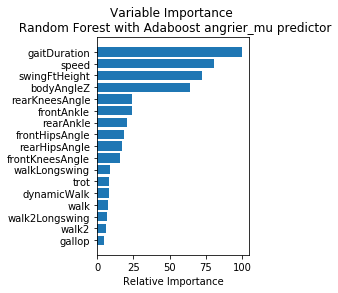

In [28]:
# #############################################################################
# Plot feature importance
feature_importance_boost = regrBoost.feature_importances_
# make importances relative to max importance
feature_importance_boost = 100.0 * (feature_importance_boost / feature_importance_boost.max())
sorted_idx_boost = np.argsort(feature_importance_boost)
pos_boost = np.arange(sorted_idx_boost.shape[0]) 
plt.subplot(1, 2, 2)
plt.barh(pos_boost, feature_importance_boost[sorted_idx_boost], align='center')
plt.yticks(pos_boost,FEATURENAMES[sorted_idx_boost])
plt.xlabel('Relative Importance')
plt.title('Variable Importance \n Random Forest with Adaboost ' + LABEL + ' predictor')
plt.show()

In [29]:
#regrBoost.estimator_weights_

In [30]:
#regrBoost.estimator_errors_

In [31]:
predicted_name ="predicted_"+LABEL

In [32]:
y_hat_regr = pd.DataFrame(ytest_pred, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr = pd.concat([y_hat_regr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_sorted = y_all_testregr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr = pd.DataFrame(ytrain_pred, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr = pd.concat([ytrain_hat_regr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_sorted = y_all_trainregr.sort_values(EMOSCORES[emotionid],ascending=[True])

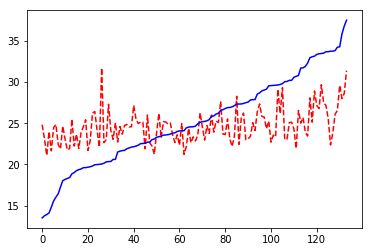

In [33]:
%matplotlib inline
plt.figure()
plt.plot(y_all_testregr_sorted[predicted_name].values,'r--',y_all_testregr_sorted[LABEL].values,'b')

Populating the interactive namespace from numpy and matplotlib


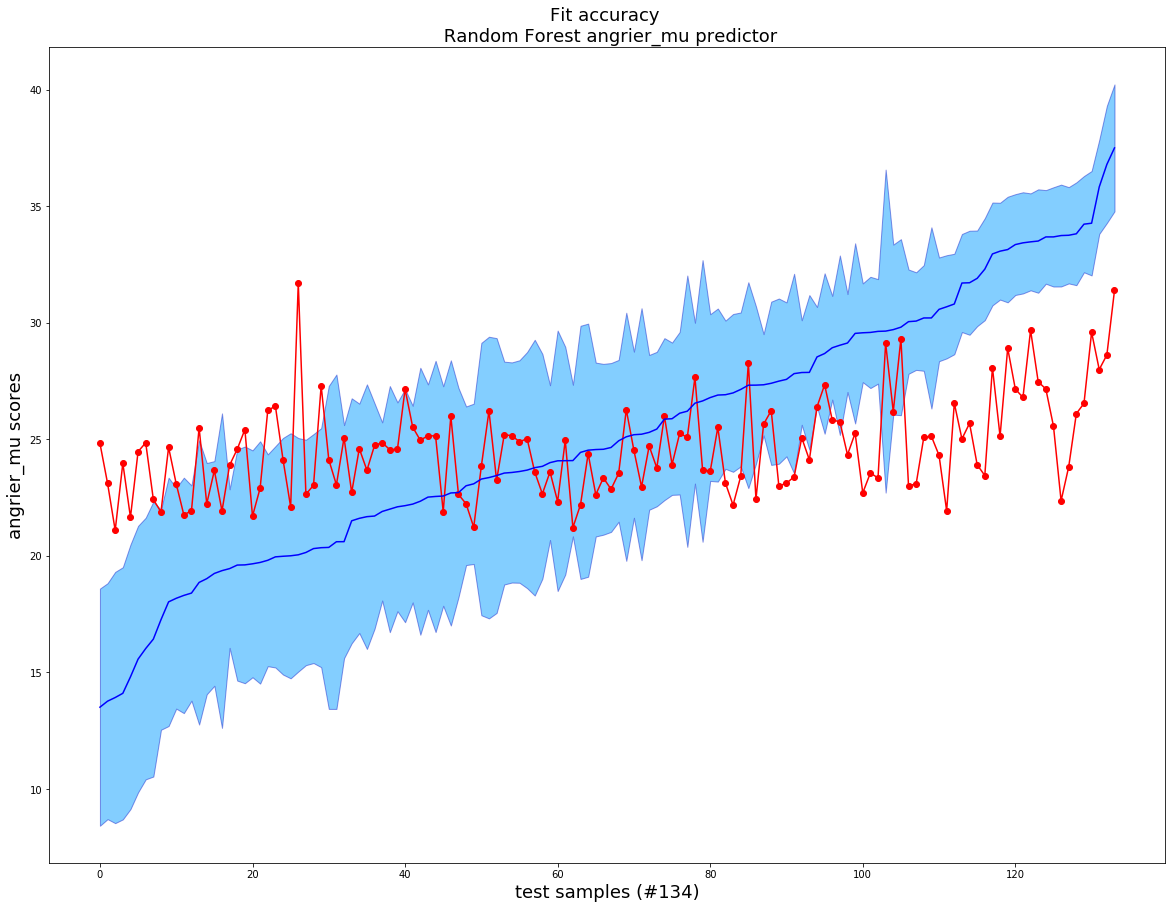

In [34]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_sorted[LABEL].values-y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_sorted[LABEL].values+y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

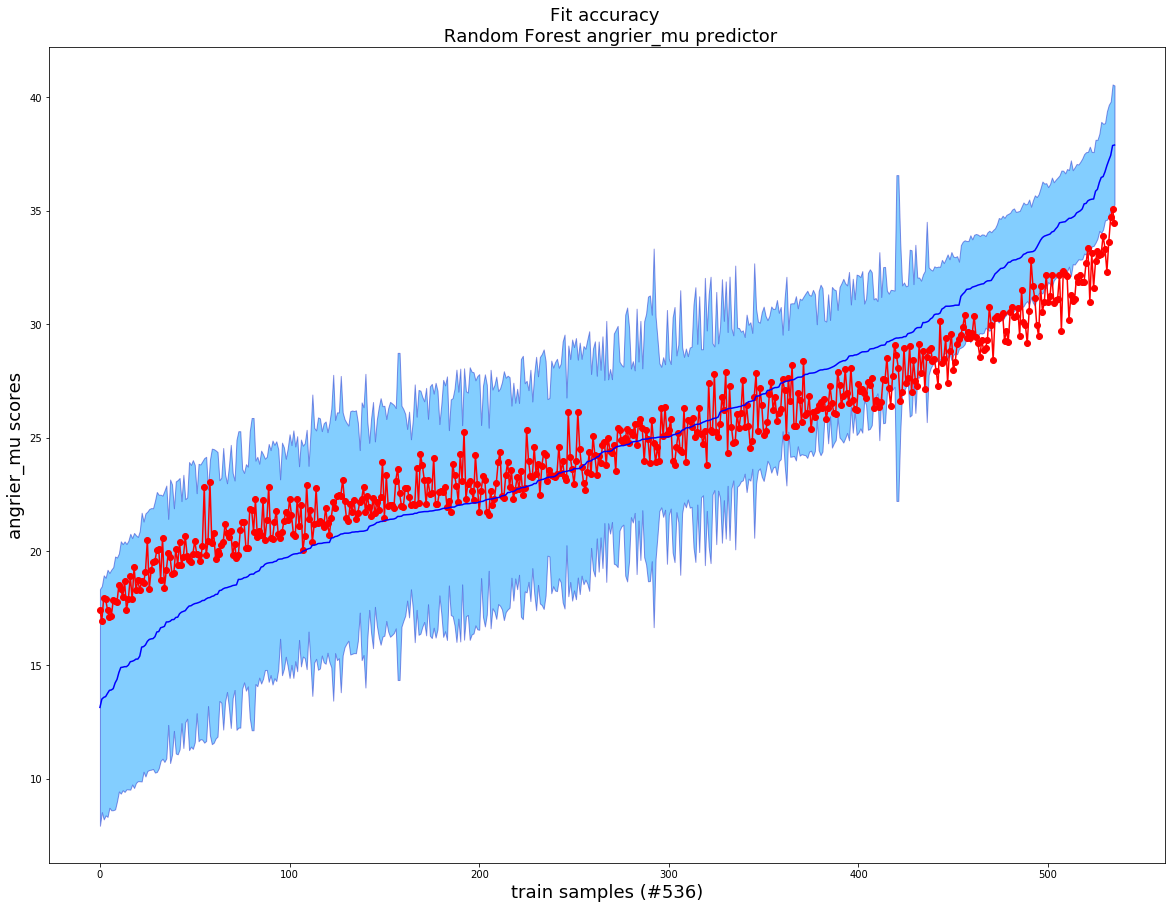

In [35]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_sorted[LABEL].values-y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_sorted[LABEL].values+y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [36]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


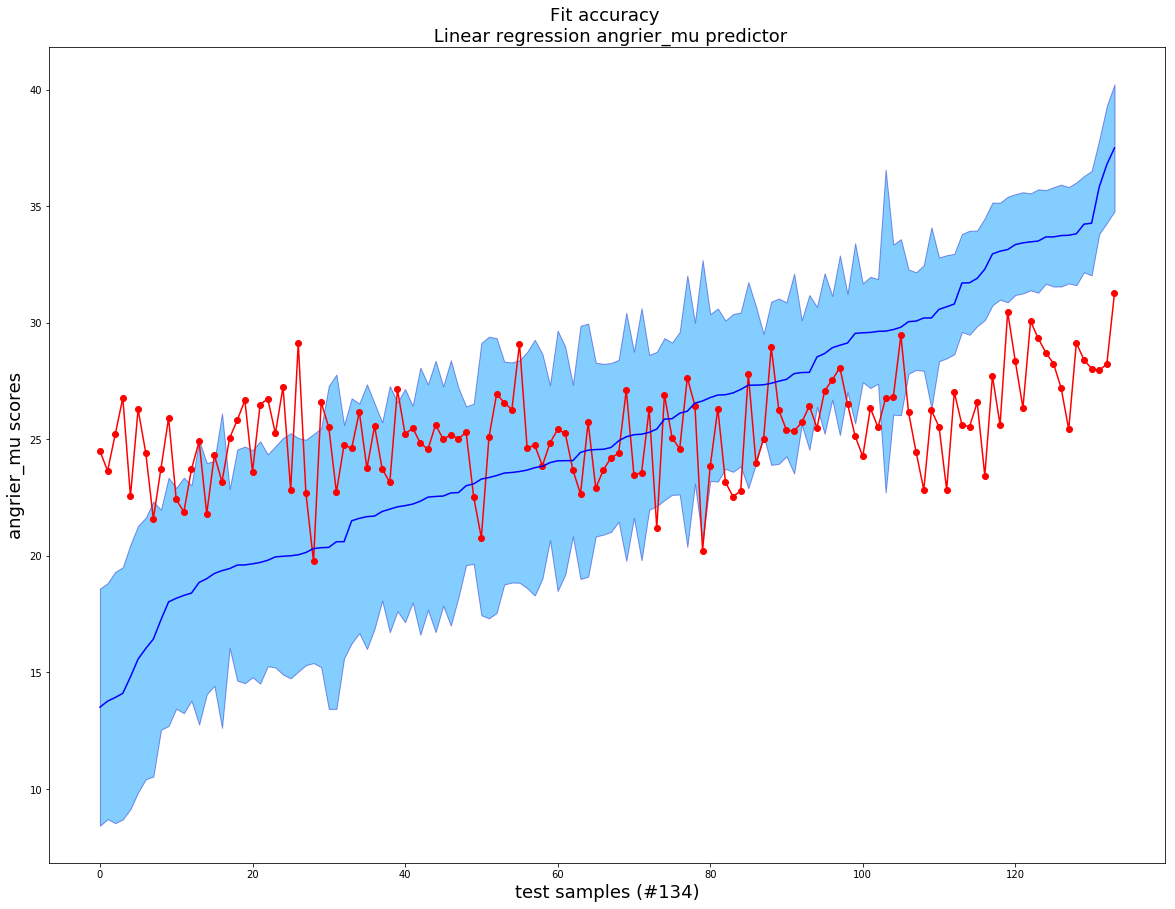

In [37]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

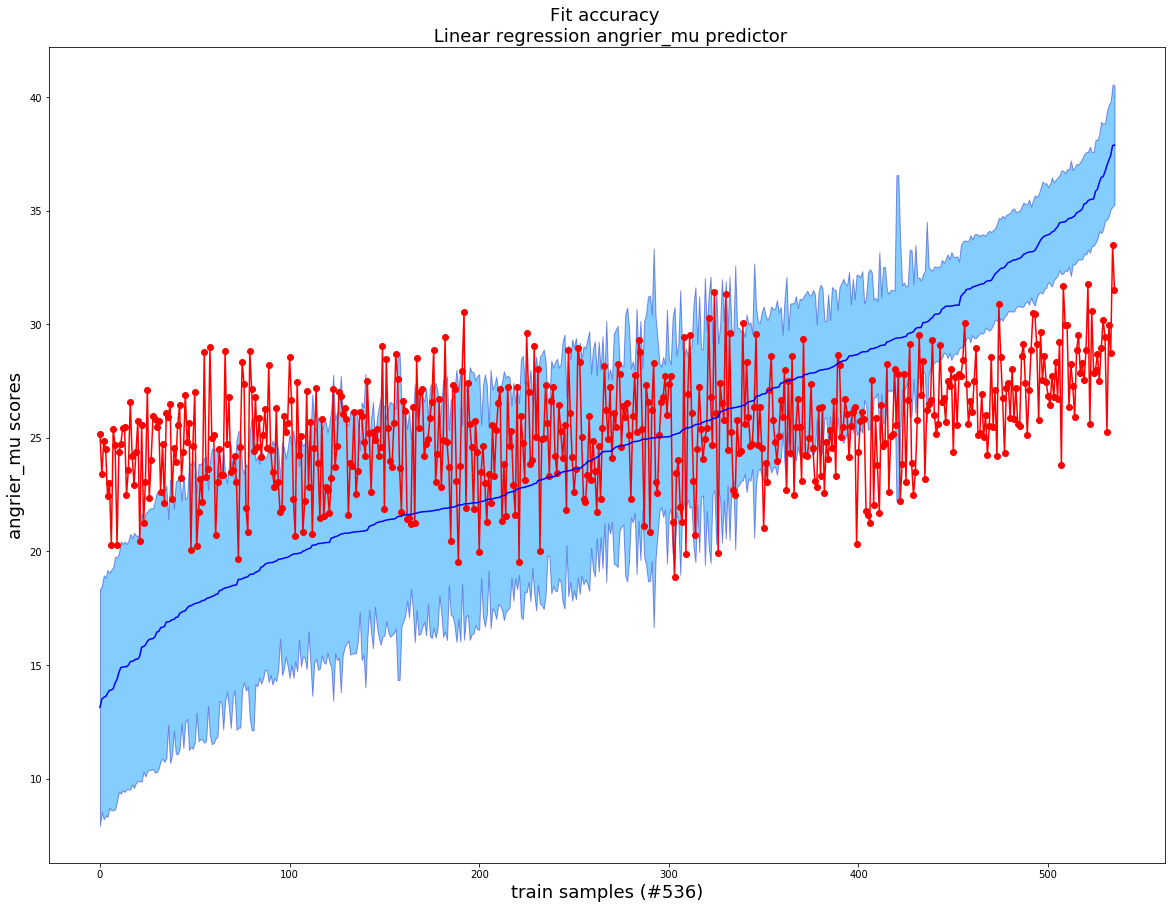

In [38]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [39]:
regr.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': True}

In [41]:
# find tree depths.. 
[estimator.tree_.max_depth for estimator in regr.estimators_]

[25,
 25,
 21,
 30,
 27,
 23,
 25,
 23,
 27,
 24,
 25,
 29,
 20,
 29,
 23,
 26,
 29,
 29,
 20,
 22,
 31,
 21,
 25,
 28,
 25,
 25,
 25,
 24,
 27,
 26,
 29,
 27,
 23,
 23,
 22,
 33,
 26,
 23,
 29,
 27,
 19,
 32,
 24,
 22,
 22,
 26,
 29,
 27,
 24,
 30,
 28,
 31,
 27,
 22,
 28,
 24,
 24,
 22,
 25,
 24,
 21,
 26,
 26,
 26,
 29,
 25,
 21,
 25,
 30,
 27,
 31,
 26,
 21,
 24,
 22,
 25,
 27,
 28,
 29,
 24,
 29,
 28,
 23,
 25,
 22,
 24,
 22,
 34,
 25,
 21,
 22,
 22,
 36,
 27,
 27,
 31,
 23,
 31,
 28,
 22,
 28,
 23,
 25,
 24,
 29,
 27,
 24,
 22,
 29,
 27,
 21,
 24,
 23,
 25,
 27,
 22,
 27,
 22,
 25,
 21,
 27,
 27,
 30,
 20,
 23,
 22,
 28,
 25,
 28,
 25,
 24,
 28,
 19,
 28,
 25,
 22,
 26,
 25,
 25,
 27,
 25,
 26,
 24,
 28,
 23,
 21,
 22,
 28,
 29,
 27,
 30,
 29,
 28,
 28,
 28,
 30,
 29,
 30,
 23,
 31,
 33,
 21,
 32,
 25,
 25,
 21,
 25,
 24,
 25,
 26,
 28,
 21,
 30,
 24,
 23,
 28,
 24,
 23,
 31,
 24,
 26,
 22,
 23,
 25,
 31,
 26,
 19,
 21,
 25,
 32,
 28,
 30,
 31,
 22,
 20,
 26,
 27,
 22,
 32,
 31,
